#Installing and Importing libraries

install the qflux package

In [1]:
!pip install qflux
#!pip install git+https://github.com/batistagroup/qflux.git@GQME_fix

  Cloning https://github.com/batistagroup/qflux.git (to revision GQME_fix) to /tmp/pip-req-build-q8po0bz2
  Running command git clone --filter=blob:none --quiet https://github.com/batistagroup/qflux.git /tmp/pip-req-build-q8po0bz2
  Running command git checkout -b GQME_fix --track origin/GQME_fix
  Switched to a new branch 'GQME_fix'
  Branch 'GQME_fix' set up to track remote branch 'GQME_fix' from 'origin'.
  Resolved https://github.com/batistagroup/qflux.git to commit 007d27eab49c392fb03ff1618977190386ee8dfc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 16.3 MB/s et

clone qflux to get some precalculated data

In [2]:
!git clone https://github.com/batistagroup/qflux.git

Cloning into 'qflux'...
remote: Enumerating objects: 1338, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 1338 (delta 183), reused 186 (delta 121), pack-reused 1009 (from 1)
Receiving objects: 100% (1338/1338), 17.74 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (670/670), done.


In [3]:
import numpy as np
import time

#parameters in the simulation
import qflux.GQME.params as pa
#read and write functions
import qflux.GQME.readwrite as wr

import matplotlib.pyplot as plt

SPIN-BOSON Model parameter
        epsilon = 1
             xi = 0.1
        omega_c = 2
      omega_max = 10
     time steps = 500
             DT = 0.00600331998021117
     final time = 3.001659990105585
          DOF_E = 2
          DOF_N = 50


#Using TT-TFD to simulate Spin-Boson Model Dynamics

In [4]:
!pip install mpsqd

In [5]:
from qflux.GQME.dynamics_GQME import DynamicsGQME

#============setup the Hamiltonian and initial state for Spin-Boson Model
Hsys = pa.EPSILON*pa.Z + pa.GAMMA_DA*pa.X
rho0 = np.zeros((pa.DOF_E,pa.DOF_E),dtype=np.complex128)
rho0[0,0] = 1.0

#Create the Spin-Boson model (SBM)
SBM = DynamicsGQME(pa.DOF_E,Hsys,rho0)
SBM.setup_timestep(pa.DT, pa.TIME_STEPS)

In [6]:
#The expected waiting time for the TT-TFD calculation is relatively long.
#To save time, the results are already pre-computed and saved.
#The following code would still run normally without running TT-TFD (Is_run_dynamics = False).
#To run the dynamics through TT-TFD, change Is_run_dynamics = True

Is_run_dynamics = False

In [7]:
#This block calculates dynamics with TT-TFD. The expected waiting time is 10 minutes on Google Colab.
if Is_run_dynamics:
  import qflux.GQME.tt_tfd as tfd

  #RDO: reduced density operator, contain the information of population and coherence
  #initial_state=0: initial at Donor state
  t, RDO_arr = SBM.tt_tfd(initial_state=0, show_steptime=True, update_type='rk4')

  #TT-TFD is time consuming, after running it once, you can read it from the file without running it again
  #output to the file
  wr.output_operator_array(t, RDO_arr, "qflux/data/GQME_Example/TTTFD_Output/TFDSigma_")

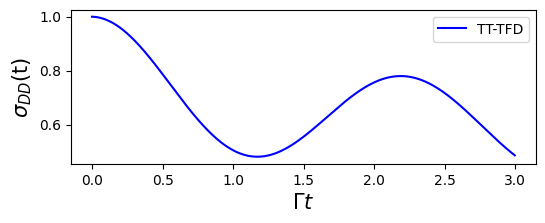

In [8]:
#read and plot
t, RDO_arr = wr.read_operator_array(pa.TIME_STEPS,"qflux/data/GQME_Example/TTTFD_Output/TFDSigma_")
plt.figure(figsize=(6,2))
plt.plot(t, RDO_arr[:,0].real,'b-', label='TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend()

#Using GQME to simulate Spin-Boson Model dynamics

##The projected Liouvillian: pure system evolution

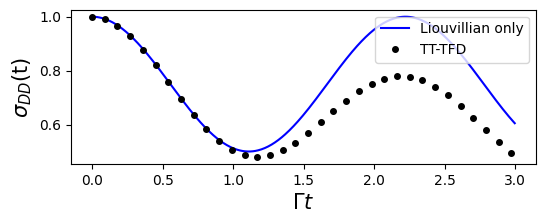

In [9]:
import scipy.linalg as LA

#propagate the pure system Liouville equation
sigma_liou = SBM.prop_puresystem()

#read TT-TFD result and plot to compare
timeVec, sigma_tt_tfd = wr.read_operator_array(pa.TIME_STEPS,"qflux/data/GQME_Example/TTTFD_Output/TFDSigma_")

plt.figure(figsize=(6,2))
plt.plot(SBM.time_array, sigma_liou[:,0].real,'b-', label='Liouvillian only')
plt.plot(timeVec,  sigma_tt_tfd[:,0].real,'ko', markersize=4,markevery=15, label='TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = 'upper right')

## Calculating the Memory Kernel

### get the propagator for memory kernel calculation

In [10]:
#The line below calculates all U elements with TT-TFD. The expected waiting time is 40 minutes on Google Colab.
#To save time, the results are already pre-computed and saved, and Is_run_dynamics is therefore set as False.
#The following code would still run normally. Please set Is_run_dynamics = True if one wishes to perform these calculations.
if Is_run_dynamics:
  print('==================now using tt-tfd to calculate propagator')
  timeVec,Gt = SBM.cal_propagator_tttfd()
  print('End of calculate propagator')

  #output the propagator
  wr.output_superoper_array(timeVec,Gt,"qflux/data/GQME_Example/U_Output/U_")
else:
  timeVec,Gt = wr.read_superoper_array(pa.TIME_STEPS,"qflux/data/GQME_Example/U_Output/U_")
  SBM.setup_propagator(Gt)

###volterra scheme: calculating the Memory kernel and output to the file

In [11]:
kernel = SBM.get_memory_kernel()

Iteration: 1
	Iteration time: 1.837153434753418
Iteration: 2
	Iteration time: 0.7782485485076904
Iteration: 3
	Iteration time: 0.8006031513214111
Iteration: 4
	Iteration time: 0.8310871124267578
Iteration: 5
	Iteration time: 0.8035752773284912
Iteration: 6
	Iteration time: 0.7899923324584961
Iteration: 7
	Iteration time: 0.7835557460784912
Iteration: 8
	Iteration time: 0.8281345367431641
Number of Iterations: 8 	Volterra time: 7.457164525985718


In [12]:
#output the kernel
wr.output_superoper_array(timeVec,kernel,"qflux/data/GQME_Example/K_Output/K_")

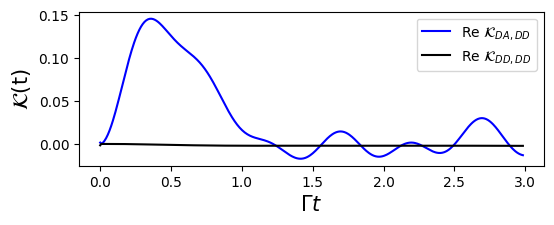

In [13]:
#plot the kernel without the last two boundary points that have numerical errors
plt.figure(figsize=(6,2))
plt.plot(timeVec[:-2], kernel[:-2,1,0].real,'b-', label='Re $\mathcal{K}_{DA,DD}$')
plt.plot(timeVec[:-2], kernel[:-2,0,0].real,'k-', label='Re $\mathcal{K}_{DD,DD}$')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\mathcal{K}$(t)',fontsize=15)
plt.legend(loc = 'upper right')

##Using QFlux to solve the GQME equation

In [14]:
sigma = SBM.solve_gqme(kernel, pa.MEM_TIME)

>>> Starting GQME propagation, memory time = 3.001659990105585
0
100
200
300
400


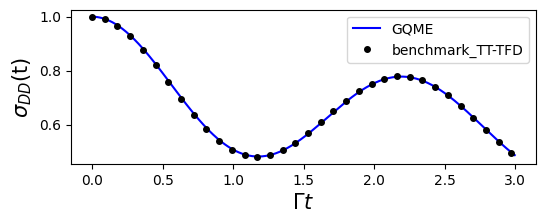

In [15]:
# Read the reference data and plot
timeVec, sigma_tt_tfd = wr.read_operator_array(pa.TIME_STEPS,"qflux/data/GQME_Example/TTTFD_Output/TFDSigma_")

plt.figure(figsize=(6,2))
plt.plot(timeVec, sigma[:,0].real,'b-', label='GQME')
plt.plot(timeVec, sigma_tt_tfd[:,0].real ,'ko', markersize=4, markevery=15, label='benchmark_TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend()

# Quantum Algorithms of GQME based on Dilation

## Solving the GQME to get the propagator

In [16]:
G_prop = SBM.solve_gqme(kernel, pa.MEM_TIME, dtype='Propagator')

>>> Starting GQME propagation, memory time = 3.001659990105585
0
100
200
300
400


## Using QFlux to perform Quantum Simulation of GQME

In [17]:
from qflux.open_systems.quantum_simulation import QubitDynamicsOS

In [19]:
qSBM = QubitDynamicsOS(rep='Density', Nsys = pa.DOF_E, Hsys = Hsys, rho0 = rho0)
qSBM.set_count_str(['000','011'])
qSBM.set_dilation_method('Sz-Nagy')

res_qc = qSBM.qc_simulation_vecdens(timeVec,Gprop=G_prop)
pop_qc = res_qc['data']

Quantum simulation step 0
At time 0 with shots = 1024 no counts for 011
At time 1 with shots = 1024 no counts for 011
At time 2 with shots = 1024 no counts for 011
At time 3 with shots = 1024 no counts for 011
At time 4 with shots = 1024 no counts for 011
At time 5 with shots = 1024 no counts for 011
At time 6 with shots = 1024 no counts for 011
At time 7 with shots = 1024 no counts for 011
At time 8 with shots = 1024 no counts for 011
At time 9 with shots = 1024 no counts for 011
At time 10 with shots = 1024 no counts for 011
At time 11 with shots = 1024 no counts for 011
At time 12 with shots = 1024 no counts for 011
At time 13 with shots = 1024 no counts for 011
At time 14 with shots = 1024 no counts for 011
At time 15 with shots = 1024 no counts for 011
At time 16 with shots = 1024 no counts for 011
At time 18 with shots = 1024 no counts for 011
At time 19 with shots = 1024 no counts for 011
At time 20 with shots = 1024 no counts for 011
At time 21 with shots = 1024 no counts for 0

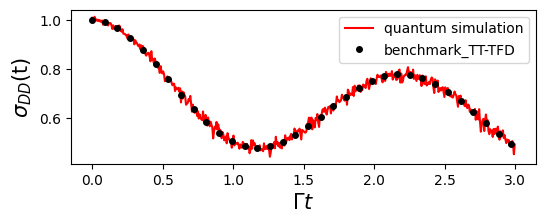

In [20]:
# Read the exact TT-TFD results
timeVec, sigma_tt_tfd = wr.read_operator_array(pa.TIME_STEPS,"qflux/data/GQME_Example/TTTFD_Output/TFDSigma_")
# Plot the population of the donor and acceptor states
plt.figure(figsize=(6,2))
plt.plot(timeVec, pop_qc[:,0], 'r-', label="quantum simulation")
plt.plot(timeVec, sigma_tt_tfd[:,0].real ,'ko', markersize=4, markevery=15, label='benchmark_TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()

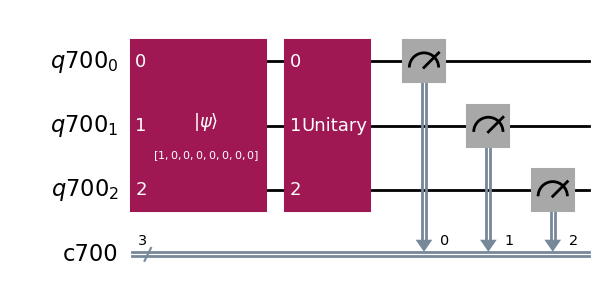

In [23]:
#visualize the quantum circuit
res_qc['circuits'][200].draw('mpl')

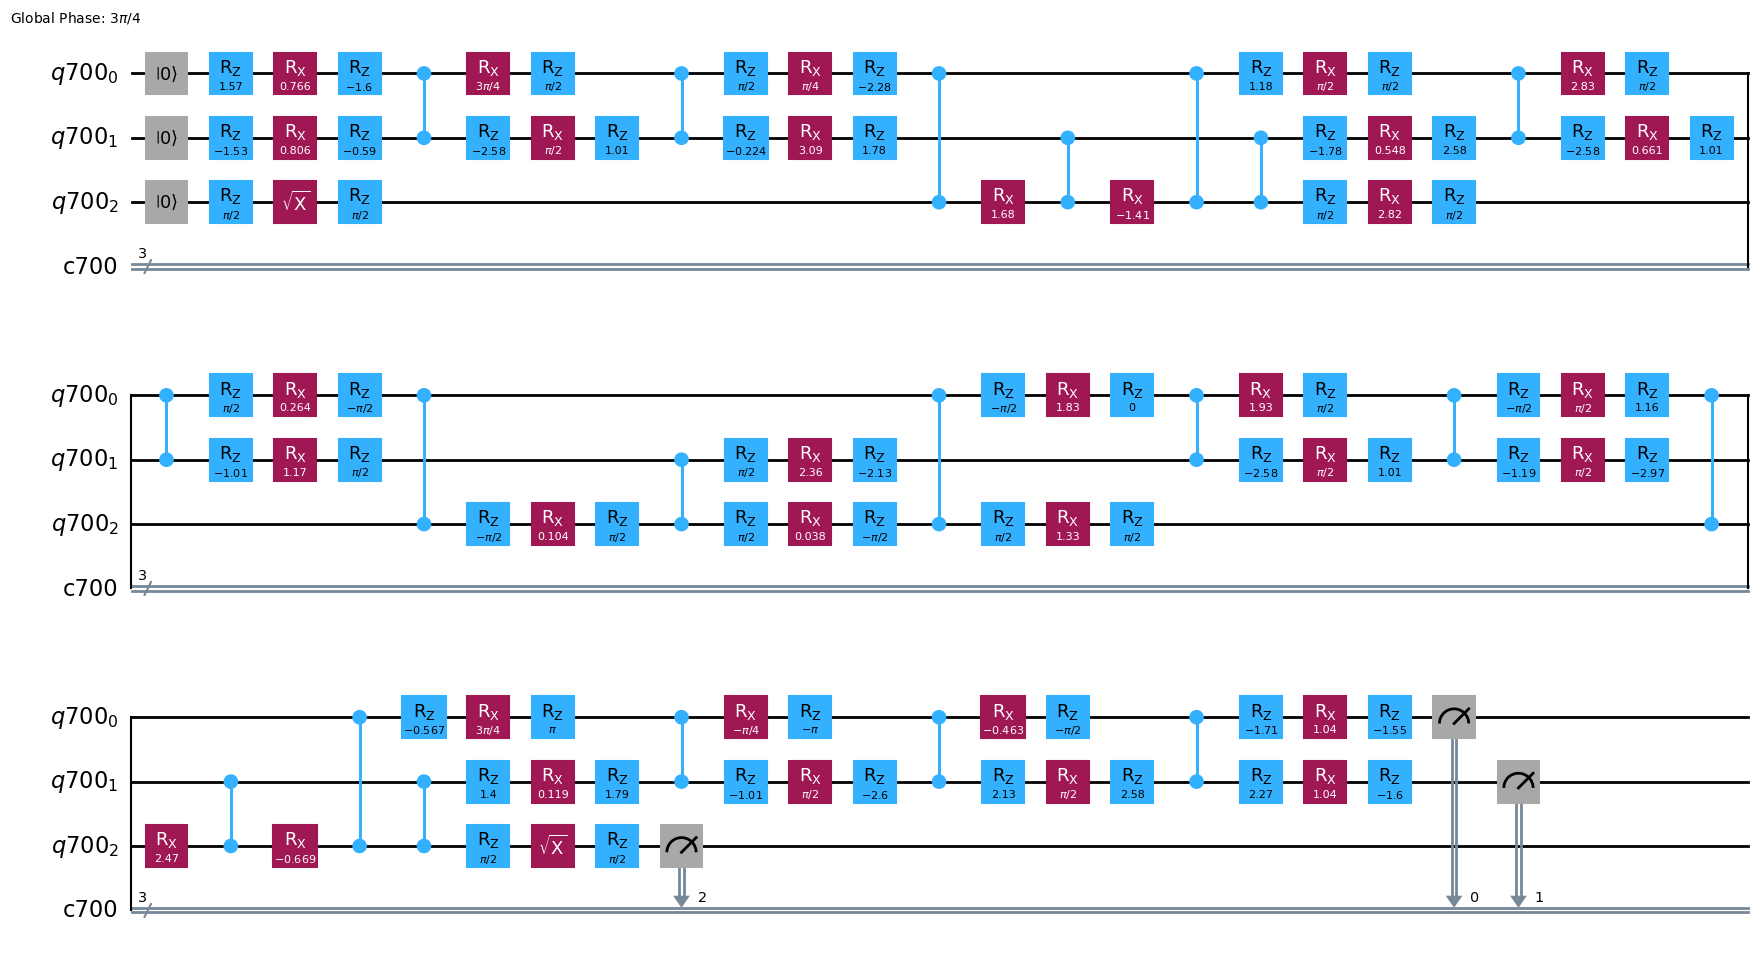

In [27]:
#visualize the complexity quantum circuit by transpiling it into a specific basis gate set.
from qiskit import transpile

basis_gates = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']
compiled_circuit = transpile(res_qc['circuits'][200], basis_gates=basis_gates, optimization_level=1)
compiled_circuit.draw('mpl')